In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
%matplotlib inline

In [56]:
df=pd.read_csv('New_Loan_Approved_Customers.csv')

In [57]:
df.columns

Index(['Loan Amount', 'Interest Rate - Charged as Flat Rate (Doesn't Accrue)',
       'Loan Tenure', 'Disbursement Date', 'Due Date', 'Repayment Amount',
       'Repayment Date', 'loan.loan_application_id',
       'Application Number (# of Times applied for 1st loan)', 'Employment',
       'Highest Education', 'Daily Income', 'Is Employed',
       'Has Other Loan Outstanding', 'Annual Income', 'Loan Purpose',
       'Loan Use Category', 'Acquisition Channel', 'Age', 'Gender',
       'Length of Phone Ownership', 'Phone is New', 'Customer Owns Phone',
       'Credit Score', 'National ID Issue Date', 'Device Type'],
      dtype='object')

In [58]:
df=df.rename(columns={'Application Number (# of Times applied for 1st loan)':'Times Applied',
                   'Loan Use Details (Free Form)':'Loan Usage',
                   'Has Other Loan Outstanding':'Outstanding',
                   'Length of Phone Ownership':'Phone Ownership',
                   'Phone is New':'New Phone'                       
                  })

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66786 entries, 0 to 66785
Data columns (total 26 columns):
Loan Amount                                              66786 non-null int64
Interest Rate - Charged as Flat Rate (Doesn't Accrue)    66786 non-null int64
Loan Tenure                                              66786 non-null int64
Disbursement Date                                        66786 non-null object
Due Date                                                 66786 non-null object
Repayment Amount                                         56767 non-null float64
Repayment Date                                           56767 non-null object
loan.loan_application_id                                 66786 non-null int64
Times Applied                                            66786 non-null int64
Employment                                               66785 non-null object
Highest Education                                        66767 non-null object
Daily Income              

Missing repayment amount and date indicates loan defaulters

Phone Ownership and New Phone have missing values (~1.5%)

Loan Use Category has missing values

In [60]:
df['Defaulter']=0
df.loc[(df['Repayment Amount'].isnull()) | (df['Repayment Amount'] < df['Loan Amount']*(1 + df['Interest Rate - Charged as Flat Rate (Doesn\'t Accrue)'] / 100)), 'Defaulter']=1

In [61]:
df['Defaulter'].sum()/df.shape[0]*100

16.849339681969276

In [62]:
df['Loan Use Category'].value_counts(normalize=True)*100

grow_business         44.873849
education             14.081006
other                 11.168676
start_business         8.322228
emergency              7.911956
medical                6.088193
other_business_use     2.898855
travel                 2.573931
travel_business        1.167927
ocassion               0.913379
Name: Loan Use Category, dtype: float64

In [63]:
df['Phone Ownership'].value_counts(normalize=True)*100

3y        27.072730
1y        19.413847
3m        16.012094
6m        13.404944
over3y    12.239627
1m        11.856759
Name: Phone Ownership, dtype: float64

In [64]:
df['New Phone'].value_counts(normalize=True)*100

Yes    80.640848
No     19.359152
Name: New Phone, dtype: float64

In [65]:
#delete rows with missing values
print(df.shape)
df=df[df['Employment'].notnull()]
df=df[df['Highest Education'].notnull()]
df=df[df['Loan Use Category'].notnull()]
df=df[df['Phone Ownership'].notnull()]
df=df[df['New Phone'].notnull()]
print(df.shape)
#1.5% data loss is not significant

(66786, 27)
(65799, 27)


In [66]:
(df['Device Type'].value_counts(normalize=True)*100).head(10)
#useless - too many categories

InfinixHOT4Lite    2.857186
Y3S                2.571468
TECNO-Y2           2.509157
TECNO-W3           2.421009
TECNO-N2S          2.188483
HUAWEIY360-U31     2.060822
InfinixHOT4        1.808538
VFD100             1.769024
VF685              1.551695
INFINIX-X551       1.369322
Name: Device Type, dtype: float64

In [67]:
df['National ID Age']=(pd.to_datetime(df['Disbursement Date'], errors='coerce')-pd.to_datetime(df['National ID Issue Date'], errors='coerce')).dt.days
#some errors in national id date format
(df['National ID Age'].value_counts(normalize=True)*100).head(10)

0       15.655253
1        1.329807
2        0.518245
3        0.243165
3653     0.238605
2557     0.209730
7670     0.197571
1826     0.189972
4        0.174775
1461     0.173255
Name: National ID Age, dtype: float64

In [68]:
#bin national ID age into buckets
df['National ID Age']=pd.cut(df['National ID Age'], [0, 1, 30, 90, 180, 365, 1095, np.inf], 
       labels=['New', '1 mth', '3 mths', '6 mths', '1 yr', '3 yrs', '3+ yrs'], include_lowest=True)

In [69]:
#bin daily income into buckets
df['Daily Income 2']=pd.cut(df['Annual Income']/365, 
                            [0, 2, 10, 20, 50, np.inf],
                            right=False,
                            labels=['Below 2', '2 to 9', '10 to 19', '20 to 49', '50 or Above'],
                            include_lowest=True                            
                           )
tmp=df.loc[df['Daily Income'] != df['Daily Income 2'], ['Daily Income', 'Daily Income 2', 'Annual Income']]
print(tmp.head(10))
tmp.shape
#There are 2146 (3.3%) discrepancies in daily income bins, between given bins & my computed ones!
#So I am gonna use my own generated bins for better accuracy

    Daily Income Daily Income 2  Annual Income
26        2 to 9       10 to 19         3680.0
51       Below 2         2 to 9          730.0
134       2 to 9       10 to 19         3650.0
136       2 to 9       10 to 19         3650.0
168       2 to 9       10 to 19         3650.0
174       2 to 9       10 to 19         3654.8
176     10 to 19       20 to 49         7300.0
212       2 to 9       10 to 19         3650.0
222     10 to 19       20 to 49         7300.0
228       2 to 9       10 to 19         3700.0


(2146, 3)

In [70]:
#consider loan as categorical variable with 4 segments - 10, 20, 30, 40
df['Loan Amount']=(df['Loan Amount']).astype(int)
df.loc[df['Repayment Amount'].isnull(), 'Repayment Amount'] = 0
df['Repayment Amount']=df['Repayment Amount']
df['Profit']=df['Repayment Amount']-df['Loan Amount']

mean        -0.127201
median       1.500000
sum      -8369.690000
Name: Profit, dtype: float64 

              Profit                  
                mean median        sum
Defaulter                             
0           2.811562   2.42  153716.54
1         -14.568239 -10.00 -162086.23


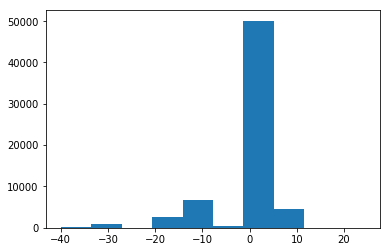

In [71]:
fig, axs = plt.subplots()
axs.hist(df['Profit'], bins=10)
print(df['Profit'].agg(['mean', 'median', 'sum']), '\n')
print(df[['Defaulter', 'Profit']].groupby(['Defaulter']).agg(['mean', 'median', 'sum']))

Net realized profit is -$8,370

In [72]:
#drop unwanted columns
df=df.drop(['Interest Rate - Charged as Flat Rate (Doesn\'t Accrue)',
            'Loan Tenure',
            'Disbursement Date',
            'Due Date',
            'Repayment Amount', 
            'Repayment Date', 
            'loan.loan_application_id',
            'Daily Income',
            'Annual Income',
            'Gender',
            'National ID Issue Date',
            'Device Type',
           ], axis=1)

In [73]:
df.columns

Index(['Loan Amount', 'Times Applied', 'Employment', 'Highest Education',
       'Is Employed', 'Outstanding', 'Loan Purpose', 'Loan Use Category',
       'Acquisition Channel', 'Age', 'Phone Ownership', 'New Phone',
       'Customer Owns Phone', 'Credit Score', 'Defaulter', 'National ID Age',
       'Daily Income 2', 'Profit'],
      dtype='object')

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65799 entries, 0 to 66785
Data columns (total 18 columns):
Loan Amount            65799 non-null int32
Times Applied          65799 non-null int64
Employment             65799 non-null object
Highest Education      65799 non-null object
Is Employed            65799 non-null object
Outstanding            65799 non-null object
Loan Purpose           65799 non-null object
Loan Use Category      65799 non-null object
Acquisition Channel    65799 non-null object
Age                    65799 non-null int64
Phone Ownership        65799 non-null object
New Phone              65799 non-null object
Customer Owns Phone    65799 non-null object
Credit Score           65799 non-null float64
Defaulter              65799 non-null int64
National ID Age        65799 non-null category
Daily Income 2         65799 non-null category
Profit                 65799 non-null float64
dtypes: category(2), float64(2), int32(1), int64(3), object(10)
memory usage: 7

In [75]:
#select all non-numeric column names
cat_vars=df.select_dtypes(exclude=[np.number]).columns
#create dummy variables and discard original categorical variables for further modeling
df2=df
#df2=df[df['Loan Amount']==10]

#df had its missing values removed, so its index got corrupted
df2=df2.reset_index(drop=True)

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df2[var], prefix=var, drop_first = True)
    df2=df2.join(cat_list)

data_vars=df2.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
df2=df2[to_keep]
len(df2.columns)

46

In [76]:
#split predictor and target columns
y=['Defaulter']
X=[i for i in df2.columns if i not in y]
if 'Profit' in X: X.remove('Profit')
#ignore 'Loan Amount' predictor
if 'Loan Amount' in X: X.remove('Loan Amount')

In [77]:
#balanced sampling
#check minority class count before sampling
print(df2[(df2['Defaulter'] == 1)].shape)
#All loan amounts
df3=df2[df2['Defaulter'] == 1].sample(11000)
#loan amount = 10
#df3=df2[df2['Defaulter'] == 1].sample(7000)
#loan amount = 20
#df3=df2[df2['Defaulter'] == 1].sample(2700)
#loan amount = 30
#df3=df2[df2['Defaulter'] == 1].sample(1100)
#loan amount = 40
#df3=df2[df2['Defaulter'] == 1].sample(200)
#All loan amounts
df3=df3.append(df2[df2['Defaulter'] == 0].sample(11000))
#loan amount = 10
#df3=df3.append(df2[df2['Defaulter'] == 0].sample(7000))
#loan amount = 20
#df3=df3.append(df2[df2['Defaulter'] == 0].sample(2700))
#loan amount = 30
#df3=df3.append(df2[df2['Defaulter'] == 0].sample(1100))
#loan amount = 40
#df3=df3.append(df2[df2['Defaulter'] == 0].sample(200))

(11126, 46)


In [78]:
#Recursive Feature Elimination
logreg = LogisticRegression()
#large beta favors higher sensitivity/recall (lesser false negatives) over precision 
ftwo_scorer = make_scorer(fbeta_score, beta = 10000)
rfe = RFECV(logreg, cv = 3, scoring = ftwo_scorer, n_jobs = 2)
rfe = rfe.fit(df3[X], df3[y])
print(rfe.support_)
print(rfe.ranking_)

c:\program files (x86)\python\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]


In [79]:
#filter out weak predictors using RFE results 
X=[x for x, i in zip(X, rfe.support_) if i==True]
len(X)

43

In [80]:
#check highly correlated predictors
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df3[X].values, i) for i in range(df3[X].shape[1])]
vif["features"] = df3[X].columns
vif[vif['VIF Factor'] >= 4]

,VIF Factor,features
4,23.074333,Employment_student
10,26.226547,Is Employed_Yes
12,217.776454,Loan Purpose_personal
14,225.618556,Loan Use Category_grow_business
18,15.613394,Loan Use Category_other_business_use
19,43.363567,Loan Use Category_start_business
21,7.626105,Loan Use Category_travel_business
39,5.119088,Daily Income 2_2 to 9
40,4.111425,Daily Income 2_10 to 19


In [81]:
#drop major & strongly correlated predictors
if 'Employment_student' in X: X.remove('Employment_student')

In [82]:
#split into training and testing data for logistic regression modeling
X_train, X_test, y_train, y_test = train_test_split(df3[X], df3[y], test_size=0.3, random_state=0)

#construct imbalanced test set
y_test2=y_test[y_test['Defaulter']==1]
X_test2=X_test[y_test['Defaulter']==1]

non_def_count=y_test.shape[0]-y_test2.shape[0]
#fetch rows in df2 but not df3 - set intersection
test2_tmp=df2.iloc[df2.index.difference(df3.index)]
#non-def are roughly 5x more than def
test2_non_def=test2_tmp[test2_tmp['Defaulter']==0].sample(non_def_count*4)

y_test2=y_test2.append(test2_non_def[y])
y_test2=y_test2.append(y_test[y_test['Defaulter']==0])
X_test2=X_test2.append(test2_non_def[X])
X_test2=X_test2.append(X_test[y_test['Defaulter']==0])
y_test2['Defaulter'].value_counts(normalize=True)
#roughly 83% non-defaulters and 17% defaulters, similar to real data

0    0.834173
1    0.165827
Name: Defaulter, dtype: float64

In [83]:
#disable scikit regularization
logreg = LogisticRegression(fit_intercept = False, C = 1e9)
weights = np.ones(len(y_train))
#setting higher weight on default cases results in more profit but lesser customers
weights[(y_train == 1).values[:,0]] = 1.3
logreg.fit(X_train, y_train, sample_weight = weights)
odds = np.exp(logreg.coef_).round(2)
odds_summary = np.vstack((np.asarray(X), odds.transpose()[:,0])).transpose()
odds_summary = pd.DataFrame(odds_summary, columns=['Factor', 'Odds Ratio'])
odds_summary['Odds Ratio'] = odds_summary['Odds Ratio'].astype(float).round(2)
odds_summary = odds_summary.sort_values(['Odds Ratio'], ascending = False)
print('Key factors influencing loan default')
odds_summary[(odds_summary['Odds Ratio'] >= 1.2) | (odds_summary['Odds Ratio'] <= 0.8)]

c:\program files (x86)\python\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Key factors influencing loan default


,Factor,Odds Ratio
20,Loan Use Category_travel_business,104.14
18,Loan Use Category_start_business,90.24
17,Loan Use Category_other_business_use,86.12
13,Loan Use Category_grow_business,78.68
11,Loan Purpose_personal,75.65
12,Loan Use Category_emergency,2.18
19,Loan Use Category_travel,1.36
14,Loan Use Category_medical,1.36
3,Employment_self_employed,1.34
15,Loan Use Category_ocassion,1.30


In [84]:
y_pred = logreg.predict(X_test2)
#model's net profit-customer base tradeoff
profit_summ=pd.merge(y_test2, df2[['Profit']], left_index=True, right_index=True)
profit_summ['Prediction']=y_pred
p1 = profit_summ['Profit'].sum()
profit_summ['Predicted Profit']=(1-profit_summ['Prediction'])*profit_summ['Profit']
p2 = profit_summ['Predicted Profit'].sum()
print('Record count:', profit_summ.shape[0])
print('Initial profit:', p1)
print('Final profit:', p2)
print('Change:', p2-p1)
orig_cust=profit_summ.shape[0]
new_cust=(profit_summ['Prediction'] == 0).sum()
diff=orig_cust-new_cust
cust_loss=round((diff/orig_cust)*100, 2)
print('New Customer Loss (%):', cust_loss, '\n')
print(profit_summ.head(10), '\n') 
print(profit_summ.tail(10))

Record count: 19840
Initial profit: -403.63
Final profit: 11445.77
Change: 11849.4
New Customer Loss (%): 62.15 

       Defaulter  Profit  Prediction  Predicted Profit
41961          1   -20.0           1              -0.0
2351           1   -10.0           1              -0.0
38456          1   -20.0           0             -20.0
6910           1   -10.0           0             -10.0
41346          1   -10.0           1              -0.0
49050          1   -10.0           1              -0.0
44603          1   -10.0           1              -0.0
38317          1   -10.0           1              -0.0
34689          1   -10.0           1              -0.0
62587          1   -10.0           1              -0.0 

       Defaulter  Profit  Prediction  Predicted Profit
31487          0     3.0           1               0.0
47241          0     1.5           1               0.0
45564          0     1.5           1               0.0
61413          0     1.5           1               0.0
1147

Overall, Net Loss turns into Net Profit with 60% reduction of new customers

For $40 loan, model unstable as data is insufficient (400 rows)